# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem

In this project we will **analyze the neighborhoods** of two important cities **New York and Toronto**. With the help of Data Analysis and Machine Learning techniques we will determine the main qualities, **similarities and differences** that the neighborhoods present, giving a reliable vision and perspective for those who want to visit both cities.

# Data

For this project we will use information provided by two sources that I will cite below.

Dataset containing relevant information from the city of **New York**: 
https://geo.nyu.edu/catalog/nyu_2451_34572

Website containing relevant information about the city of **Toronto**: 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.

This information is essential to respond to our analysis as it contains longitude, latitude and corresponding neighborhood of each city, we also have the **Foursquare API** that provides us with additional information as more relevant places that make up each neighborhood and their respective information provided by visitors.

To respond to our problem, we will use the information provided and we will categorize and segment it to later graph it and be able to explain through a statistical summary the main factors that occur in each neighborhood and how they are related, we can also give a clear perspective of the similarities and differences between New York and Toronto.


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

Solving environment: done

# All requested packages already installed.



## Download and Explore New York Dataset

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Quick look at the data

In [6]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

It is important to keep in mind that the relevant information for our analysis is found in *features key*, which is basically a list of the neighborhoods.

First New York neighborhood in our Dataset

In [7]:
NY_neigh_data = newyork_data['features']
NY_neigh_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Transforming the data into pandas dataframe

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

In [9]:
for data in NY_neigh_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
ny_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ny_neighborhoods['Borough'].unique()),
        ny_neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


Now we have a Dataframe with information that we can work later composed of: Borough, Neighborhood, Latitude, Longitude as features with 5 boroughs and 306 neighborhoods.

### Using geopy library to get the latitude and longitude values of New York.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with neighborhoods superimposed on top.

In [13]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_neighborhoods['Latitude'], ny_neighborhoods['Longitude'], ny_neighborhoods['Borough'], ny_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF6666',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Download and Explore Toronto Dataset

First we will download information corresponding to the neighborhoods in Canada.

### Data Scrape from Wikipedia using BeautifulSoup.

In [15]:
r = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(r.content,'lxml')
table = soup.find_all('table')[0]
table = pd.read_html(str(table))

### Transforming the data into pandas dataframe

In [16]:
df=pd.DataFrame(table[0]) 
df.rename(columns = {'Postcode': 'PostalCode', 'Neighbourhood':'Neighborhood'}, inplace =True)
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Processing the cells that have an assigned borough.

In [17]:
df_1 = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)
df_1.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


### Combining columns with the same PostalCode.

In [18]:
df_2 = df_1.groupby(['PostalCode','Borough'], as_index = False).agg(lambda Neig: ', '.join(Neig))
df_2.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Assigning the name of the corresponding borough to all neighborhoods that have 'Not assigned'.

In [19]:
for i,row in enumerate(df_2['Neighborhood']):
    if row=='Not assigned':
        df_2.loc[i,'Neighborhood'].replace('Not assigned', df_2.loc[i,'Borough'], inplace= True)

In [20]:
df_2.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Downloading csv file coordinates.

In [21]:
URL = 'http://cocl.us/Geospatial_data'
geo_cor = pd.read_csv(URL)
geo_cor.rename(columns = {'Postal Code': 'PostalCode'}, inplace =True)
geo_cor.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging both dataframes.

In [22]:
df_Canada = df_2.merge(geo_cor, on = 'PostalCode')
df_Canada.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


At this point we already have all the information we need for our subsequent analysis corresponding to Borough, Neighborhood, Latitude, Longitude. But we only want data from the city of Toronto, so the next step is to filter that information.

### Filtering only boroughs that contain the word Toronto.

In [23]:
tor_neighborhoods = df_Canada[df_Canada['Borough'].str.contains(pat='Toronto')].reset_index(drop=True)
tor_neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [24]:
print('The dataframe has {} boroughs and {} neighborhoods corresponding to Toronto.'.format(
        len(tor_neighborhoods['Borough'].unique()),
        tor_neighborhoods.shape[0]))

The dataframe has 4 boroughs and 39 neighborhoods corresponding to Toronto.


### Using geopy library to get the latitude and longitude values of Toronto.

In [25]:
address = 'Toronto'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
tor_latitude = location.latitude
tor_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(tor_latitude, tor_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


### Create a map of Toronto with neighborhoods superimposed on top.

In [26]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(tor_neighborhoods['Latitude'], tor_neighborhoods['Longitude'], tor_neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Methodology

In this section we will explore and analyze both cities. First, we will individually analyze each city with the help of Foursquare, we will look for the most visited places by neighborhood, together with important statistics that will help us understand its main characteristics, second we will compare both cities in search of similarities and differences, we will use the k-means clustering algorithm To segment the neighborhoods and discover which neighborhoods in both cities share fundamental characteristics in relation to the most emblematic places of each cluster, we will also use bar graphs that will help us visualize each cluster.

# Analysis

### Foursquare Credentials

In [27]:
# The code was removed by Watson Studio for sharing.

### Explore Neighborhoods in New York

In [28]:
LIMIT = 20 
radius = 500 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
ny_venues = getNearbyVenues(names=ny_neighborhoods['Neighborhood'],
                                   latitudes=ny_neighborhoods['Latitude'],
                                   longitudes=ny_neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

### Venues in New York within each neighborhood

In [30]:
print(ny_venues.shape)
ny_venues.head()

(4793, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


### Number of venues for each neighborhood

In [31]:
ny_num_venues = ny_venues.groupby('Neighborhood').count()
ny_num_venues = ny_num_venues.loc[:,'Neighborhood Latitude']
ny_num_venues=pd.DataFrame(data=ny_num_venues)
ny_num_venues.rename(columns={'Neighborhood Latitude':'Venues for each Neighborhood'}, inplace=True)
ny_num_venues.head(15)

,Venues for each Neighborhood
Neighborhood,
Allerton,20
Annadale,11
Arden Heights,5
Arlington,6
Arrochar,19
Arverne,18
Astoria,20
Astoria Heights,13
Auburndale,18


In [32]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 368 uniques categories.


### Analyze Each Neighborhood

In [33]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Vietnamese Restaurant,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


New DataFrame size:

In [34]:
ny_onehot.shape

(4793, 368)

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [35]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Vietnamese Restaurant,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
1,Annadale,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.090909,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
2,Arden Heights,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
3,Arlington,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.166667,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
4,Arrochar,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
5,Arverne,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.055556,0.000000,0.000000
6,Astoria,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
7,Astoria Heights,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
8,Auburndale,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.055556,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000
9,Bath Beach,0.000000,0.00,0.0,0.0000,0.000000,0.00,0.000000,0.00,0.00,...,0.00,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000


In [36]:
ny_grouped.shape

(300, 368)

10 most common venues into DataFrame 

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

New DataFrame with the top 10 venues for each neighborhood

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_neigh_venues = pd.DataFrame(columns=columns)
ny_neigh_venues['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_neigh_venues.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

ny_neigh_venues.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Grocery Store,Discount Store,Breakfast Spot,Fried Chicken Joint,Supermarket,Fast Food Restaurant,Gas Station,Martial Arts Dojo,Spanish Restaurant
1,Annadale,Pizza Place,Bakery,American Restaurant,Restaurant,Liquor Store,Diner,Train Station,Dance Studio,Pub,Sports Bar
2,Arden Heights,Pool,Playground,Pizza Place,Coffee Shop,Pharmacy,Women's Store,Falafel Restaurant,Empanada Restaurant,English Restaurant,Entertainment Service
3,Arlington,Bus Stop,Deli / Bodega,Grocery Store,American Restaurant,Boat or Ferry,Field,Ethiopian Restaurant,Event Service,Event Space,Factory
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Polish Restaurant,Athletics & Sports,Food Truck,Middle Eastern Restaurant,Supermarket,Mediterranean Restaurant,Taco Place


In [39]:
ny_venue_analisis = ny_neigh_venues[['Neighborhood', '1st Most Common Venue']]
ny_venue_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences', '1st Most Common Venue':'Venues'}, inplace=True)
ny_venue_analisis = ny_venue_analisis.groupby('Venues').count()
# 1st Most Common Venues whith more than 1 ocurence in cluster 1
ny_venue_analisis = ny_venue_analisis.loc[ny_venue_analisis['Total Number of Occurrences'] > 1]
ny_venue_analisis

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Total Number of Occurrences
Venues,
Bagel Shop,5
Bakery,4
Bank,11
Bar,10
Baseball Field,2
Beach,7
Brewery,2
Bubble Tea Shop,2
Bus Station,5


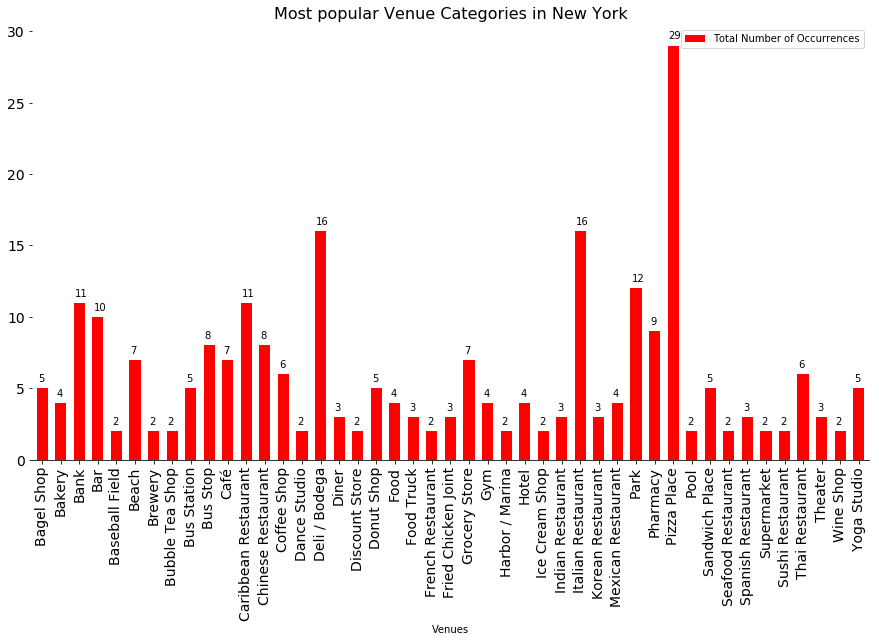

In [40]:
ax = ny_venue_analisis.plot(kind = 'bar',
                 figsize = (15, 8),
                 width = 0.6,
                 color = ['red'],
                 fontsize = 14
                 )
ax.set_title('Most popular Venue Categories in New York', fontsize = 16)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for percentage in ax.patches:
    ax.annotate(str(percentage.get_height()), xy =(percentage.get_x()+0.06,percentage.get_height()+0.45))

### Explore Neighborhoods in Toronto

### Toronto Venues

In [41]:
LIMIT = 100 
radius = 500 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
tor_venues = getNearbyVenues(names=tor_neighborhoods['Neighborhood'],
                                   latitudes=tor_neighborhoods['Latitude'],
                                   longitudes=tor_neighborhoods['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

### Venues in Toronto within each neighborhood

In [43]:
print(tor_venues.shape)
tor_venues.head()

(1721, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


### Number of venues for each neighborhood

In [45]:
tor_num_venues = tor_venues.groupby('Neighborhood').count()
tor_num_venues = tor_num_venues.loc[:,'Neighborhood Latitude']
tor_num_venues=pd.DataFrame(data=tor_num_venues)
tor_num_venues.rename(columns={'Neighborhood Latitude':'venues for each neighborhood'}, inplace=True)
tor_num_venues

,venues for each neighborhood
Neighborhood,
"Adelaide, King, Richmond",100
Berczy Park,56
"Brockton, Exhibition Place, Parkdale Village",24
Business Reply Mail Processing Centre 969 Eastern,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17
"Cabbagetown, St. James Town",46
Central Bay Street,81
"Chinatown, Grange Park, Kensington Market",86
Christie,18


### Unique categories

In [46]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 232 uniques categories.


### Analyze Each Neighborhood

In [47]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhood'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### New DataFrame size:

In [48]:
tor_onehot.shape

(1721, 232)

### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [49]:
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
tor_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.000000,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,"Brockton, Exhibition Place, Parkdale Village",0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.000000,0.000000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.012346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012346,...,0.000000,0.00000,0.00,0.012346,0.000000,0.000000,0.012346,0.000000,0.000000,0.00
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.034884,0.000000,0.058140,0.011628,0.000000,0.000000,0.00
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011628,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011628,...,0.000000,0.00000,0.00,0.000000,0.000000,0.011628,0.000000,0.011628,0.011628,0.00


In [50]:
tor_grouped.shape

(39, 232)

### 10 most common venues into DataFrame

In [51]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### New DataFrame with the top 10 venues for each neighborhood.

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
neighborhoods_venues_sorted.shape


(39, 11)

In [53]:
tor_venue_analisis = neighborhoods_venues_sorted[['Neighborhood', '1st Most Common Venue']]
tor_venue_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences', '1st Most Common Venue':'Venues'}, inplace=True)
tor_venue_analisis = tor_venue_analisis.groupby('Venues').count()
# 1st Most Common Venues whith more than 1 ocurence in cluster 1
tor_venue_analisis = tor_venue_analisis.loc[tor_venue_analisis['Total Number of Occurrences'] > 1]
tor_venue_analisis

,Total Number of Occurrences
Venues,
Bar,2
Café,4
Coffee Shop,15
Park,4


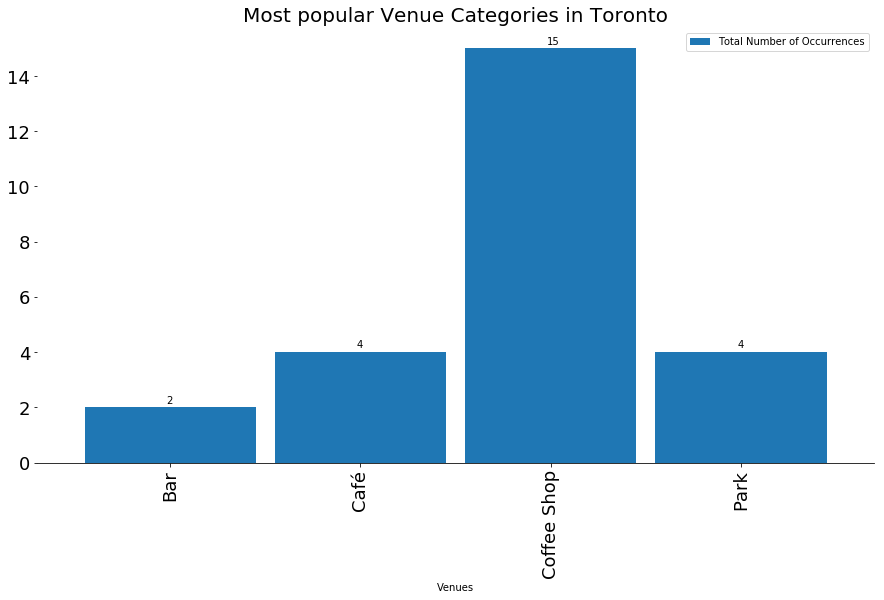

In [54]:
ax = tor_venue_analisis.plot(kind = 'bar',
                 figsize = (15, 8),
                 width = 0.9,
               
                 fontsize = 18
                             
                 )
ax.set_title('Most popular Venue Categories in Toronto', fontsize = 20)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for percentage in ax.patches:
    ax.annotate(str(percentage.get_height()), xy =(percentage.get_x()+0.43,percentage.get_height()+0.15))

### Join both data sets

In this section we will proceed to join both data sets to later make clusters and segment all the information acquired in order to find similarities between neighborhoods corresponding to both cities.

In [55]:
print(ny_neighborhoods.shape)

toronto_neighborhoods = tor_neighborhoods.drop(['PostalCode'], 1)
print(toronto_neighborhoods.shape)

both_data = toronto_neighborhoods.append(ny_neighborhoods)
print(both_data.shape)
both_data.head()

(306, 4)
(39, 4)
(345, 4)


,Borough,Neighborhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790


In [56]:
both_onehot = pd.get_dummies(tor_venues[['Venue Category']].append(ny_venues[['Venue Category']]), prefix="", prefix_sep="")
both_onehot['Neighborhood'] = tor_venues['Neighborhood'].append(ny_venues['Neighborhood']) 

#move neighborhood column to the first column
fixed_columns = [both_onehot.columns[-1]] + list(both_onehot.columns[:-1])
both_onehot = both_onehot[fixed_columns]

both_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Vietnamese Restaurant,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
both_grouped = both_onehot.groupby('Neighborhood').mean().reset_index()
both_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Vietnamese Restaurant,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01
1,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
3,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
4,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00


In [58]:
both_grouped.shape

(338, 402)

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
both_venues_sorted = pd.DataFrame(columns=columns)
both_venues_sorted['Neighborhood'] = both_grouped['Neighborhood']

for ind in np.arange(both_grouped.shape[0]):
    both_venues_sorted.iloc[ind, 1:] = return_most_common_venues(both_grouped.iloc[ind, :], num_top_venues)

both_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Thai Restaurant,Café,Bar,Sushi Restaurant,Pizza Place,Steakhouse,Lounge,Hotel
1,Allerton,Pizza Place,Breakfast Spot,Supermarket,Donut Shop,Fast Food Restaurant,Martial Arts Dojo,Chinese Restaurant,Grocery Store,Discount Store,Fried Chicken Joint
2,Annadale,Pizza Place,Sports Bar,Bakery,Dance Studio,American Restaurant,Diner,Restaurant,Train Station,Pub,Liquor Store
3,Arden Heights,Pharmacy,Coffee Shop,Pool,Playground,Pizza Place,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant
4,Arlington,Bus Stop,Grocery Store,Boat or Ferry,Deli / Bodega,American Restaurant,Event Service,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant


In [60]:
both_venues_sorted.shape

(338, 11)

## Cluster Neighborhoods

### Choosing K using the elbow method

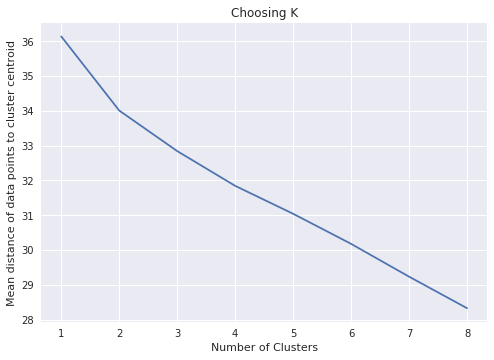

In [61]:
plt.style.use("seaborn")
Ks = 9
mean_square_error = np.zeros((Ks-1))

df_both_grouped = both_grouped.drop(['Neighborhood'],axis= 1)
for n in range(1,Ks):
    k = n
    
    K_means = KMeans(n_clusters=k, random_state=0,init = 'k-means++', n_init = 12).fit(df_both_grouped)
    mean_square_error[n-1] = K_means.inertia_
    #print(mean_square_error[n-1])

plt.plot(range(1,Ks),mean_square_error)
plt.xlabel("Number of Clusters")
plt.ylabel("Mean distance of data points to cluster centroid")
plt.title("Choosing K")
plt.show()

### Run k-means to cluster the neighborhood into 8 clusters.

In [62]:
# set number of clusters
kclusters = 8

grouped_clustering = both_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 7, 7, 5, 5, 5, 5], dtype=int32)

In [63]:
# add clustering labels
both_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

both_merged = both_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
both_merged = both_merged.join(both_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



print(both_merged.shape)
both_merged.dropna(subset=['Cluster Labels'], inplace =True)
print(both_merged.shape)
convert = {'Cluster Labels': int} 
  
both_merged = both_merged.astype(convert) 
both_merged.head() # check the last columns!

(345, 15)
(343, 15)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,The Beaches,43.676357,-79.293031,5,Pub,Trail,Health Food Store,Women's Store,English Restaurant,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop
1,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store,Juice Bar
2,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,1,Park,Ice Cream Shop,Italian Restaurant,Brewery,Fish & Chips Shop,Movie Theater,Steakhouse,Burrito Place,Sushi Restaurant,Liquor Store
3,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Gastropub,American Restaurant,Bakery,Brewery,Italian Restaurant,Ice Cream Shop,Seafood Restaurant,Sandwich Place
4,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Bus Line,Park,Swim School,Women's Store,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store


In [64]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(both_merged['Latitude'], both_merged['Longitude'], both_merged['Neighborhood'], both_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [65]:
cluster_1 = both_merged.loc[both_merged['Cluster Labels'] == 0, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Davisville,Pizza Place,Sandwich Place,Dessert Shop,Gym,Coffee Shop,Sushi Restaurant,Café,Italian Restaurant,Thai Restaurant,Gas Station
0,Wakefield,Pharmacy,Ice Cream Shop,Laundromat,Sandwich Place,Gas Station,Dessert Shop,Donut Shop,Caribbean Restaurant,Factory,Event Space
1,Co-op City,Bus Station,Ice Cream Shop,Deli / Bodega,Gift Shop,Bagel Shop,Basketball Court,Grocery Store,Park,Discount Store,Restaurant
5,Kingsbridge,Mexican Restaurant,Spanish Restaurant,Pizza Place,Trail,Burger Joint,Beer Bar,Caribbean Restaurant,Bar,Sandwich Place,Latin American Restaurant
6,Marble Hill,Gym,Coffee Shop,Ice Cream Shop,Steakhouse,Seafood Restaurant,Sandwich Place,Pizza Place,Pharmacy,Miscellaneous Shop,Donut Shop


In [66]:
cluster_1_analisis = cluster_1[['Neighborhood', '1st Most Common Venue']]
cluster_1_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 1', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_1_analisis = cluster_1_analisis.groupby('Venues').count()
# 1st Most Common Venues whith more than 1 ocurence in cluster 1
cluster_1_analisis = cluster_1_analisis.loc[cluster_1_analisis['Total Number of Occurrences in Cluster 1'] > 1]
cluster_1_analisis

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Total Number of Occurrences in Cluster 1
Venues,
Bank,5
Caribbean Restaurant,3
Chinese Restaurant,2
Deli / Bodega,4
Donut Shop,6
Fried Chicken Joint,2
Grocery Store,3
Ice Cream Shop,5
Indian Restaurant,2


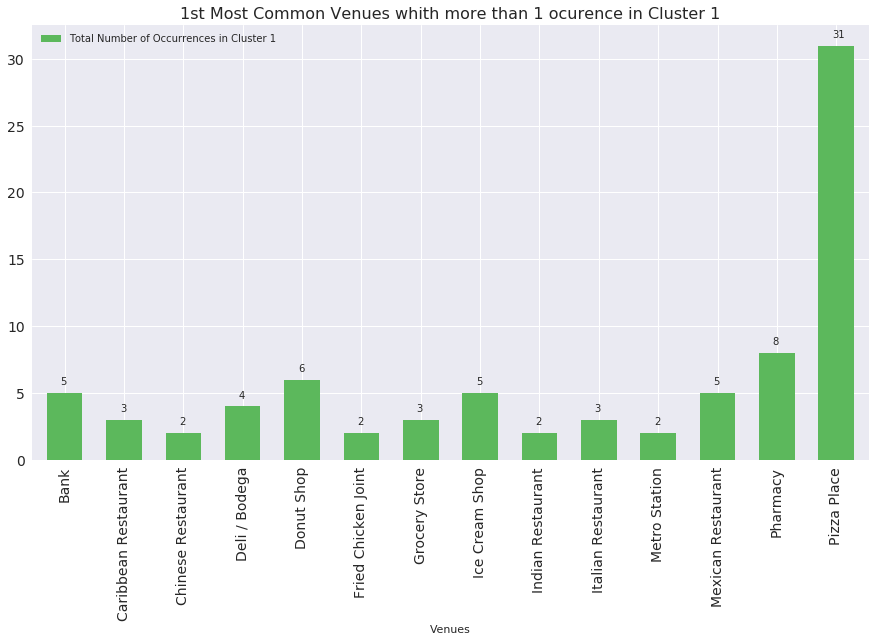

In [89]:
ax = cluster_1_analisis.plot(kind = 'bar',
                 figsize = (15, 8),
                 width = 0.6,
                 color = ['#5cb85c'],
                 fontsize = 14
                 )
ax.set_title('1st Most Common Venues whith more than 1 ocurence in Cluster 1', fontsize = 16)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for percentage in ax.patches:
    ax.annotate(str(percentage.get_height()), xy =(percentage.get_x()+0.23, percentage.get_height()+0.60))

## Cluster 2

In [68]:
cluster_2 = both_merged.loc[both_merged['Cluster Labels'] == 1, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Pub,Pizza Place,Liquor Store,Juice Bar
2,"The Beaches West, India Bazaar",Park,Ice Cream Shop,Italian Restaurant,Brewery,Fish & Chips Shop,Movie Theater,Steakhouse,Burrito Place,Sushi Restaurant,Liquor Store
3,Studio District,Café,Coffee Shop,Gastropub,American Restaurant,Bakery,Brewery,Italian Restaurant,Ice Cream Shop,Seafood Restaurant,Sandwich Place
6,North Toronto West,Clothing Store,Coffee Shop,Yoga Studio,Dessert Shop,Spa,Mexican Restaurant,Café,Sporting Goods Shop,Chinese Restaurant,Salon / Barbershop
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Pub,Coffee Shop,Sports Bar,American Restaurant,Bagel Shop,Light Rail Station,Liquor Store,Sushi Restaurant,Restaurant,Park


In [69]:
cluster_2_analisis = cluster_2[['Neighborhood', '1st Most Common Venue']]
cluster_2_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 2', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_2_analisis = cluster_2_analisis.groupby('Venues').count()
# 1st Most Common Venues whith more than 1 ocurence in cluster 1
cluster_2_analisis = cluster_2_analisis.loc[cluster_2_analisis['Total Number of Occurrences in Cluster 2'] > 1]
cluster_2_analisis

,Total Number of Occurrences in Cluster 2
Venues,
Art Gallery,2
Bakery,3
Bar,11
Café,8
Clothing Store,2
Coffee Shop,21
Cosmetics Shop,2
Hotel,2
Italian Restaurant,5


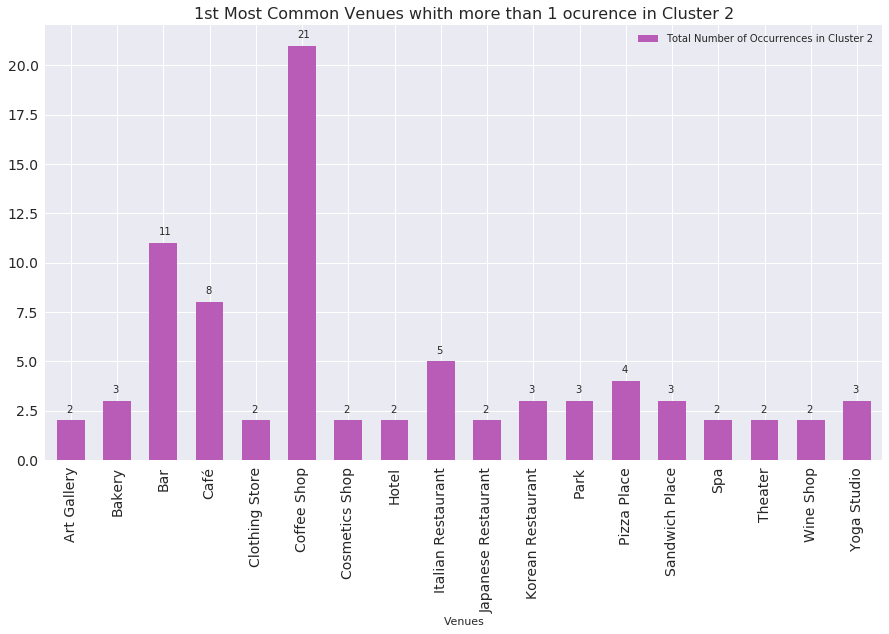

In [90]:
ax = cluster_2_analisis.plot(kind = 'bar',
                 figsize = (15, 8),
                 width = 0.6,
                 color = ['#b85cb8'],
                 fontsize = 14
                 )
ax.set_title('1st Most Common Venues whith more than 1 ocurence in Cluster 2', fontsize = 16)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for percentage in ax.patches:
    ax.annotate(str(percentage.get_height()), xy =(percentage.get_x()+0.20, percentage.get_height()+0.40))

## Cluster 3

In [71]:
cluster_3 = both_merged.loc[both_merged['Cluster Labels'] == 2, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_3.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Lawrence Park,Bus Line,Park,Swim School,Women's Store,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
27,Clason Point,Park,Pool,Boat or Ferry,Grocery Store,South American Restaurant,Bus Stop,Women's Store,Entertainment Service,Dumpling Restaurant,Duty-free Shop
192,Somerville,Park,Women's Store,Ethiopian Restaurant,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant
203,Todt Hill,Park,Women's Store,Ethiopian Restaurant,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant
303,Bayswater,Park,Playground,Women's Store,Entertainment Service,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant


In [72]:
cluster_3_analisis = cluster_3[['Neighborhood', '1st Most Common Venue']]
cluster_3_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 3', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_3_analisis = cluster_3_analisis.groupby('Venues').count()
# 1st Most Common Venues whith more than 1 ocurence in cluster 1
cluster_3_analisis = cluster_3_analisis.loc[cluster_3_analisis['Total Number of Occurrences in Cluster 3'] > 1]
cluster_3_analisis

,Total Number of Occurrences in Cluster 3
Venues,
Park,4


## Cluster 4

In [73]:
cluster_4 = both_merged.loc[both_merged['Cluster Labels'] == 3, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_4.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
202,Grymes Hill,Dog Run,Ethiopian Restaurant,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant


In [85]:
cluster_4_analisis = cluster_4[['Neighborhood', '1st Most Common Venue']]
cluster_4_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 4', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_4_analisis = cluster_4_analisis.groupby('Venues').count()

cluster_4_analisis

,Total Number of Occurrences in Cluster 4
Venues,
Dog Run,1


## Cluster 5

In [74]:
cluster_5 = both_merged.loc[both_merged['Cluster Labels'] == 4, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_5.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
255,Emerson Hill,Food,Ethiopian Restaurant,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant


In [86]:
cluster_5_analisis = cluster_5[['Neighborhood', '1st Most Common Venue']]
cluster_5_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 5', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_5_analisis = cluster_5_analisis.groupby('Venues').count()

cluster_5_analisis

,Total Number of Occurrences in Cluster 5
Venues,
Food,1


## Cluster 6

In [75]:
cluster_6 = both_merged.loc[both_merged['Cluster Labels'] == 5, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_6.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,The Beaches,Pub,Trail,Health Food Store,Women's Store,English Restaurant,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop
5,Davisville North,Department Store,Hotel,Breakfast Spot,Food & Drink Shop,Park,Gym,Sandwich Place,English Restaurant,Dry Cleaner,Dumpling Restaurant
8,"Moore Park, Summerhill East",Trail,Playground,Women's Store,Entertainment Service,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant
10,Rosedale,Park,Bus Station,Cosmetics Shop,Smoke Shop,Sandwich Place,Liquor Store,Chinese Restaurant,Jewelry Store,Trail,Supermarket
22,Roselawn,Garden,Pool,Health & Beauty Service,Women's Store,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store


In [76]:
cluster_6_analisis = cluster_6[['Neighborhood', '1st Most Common Venue']]
cluster_6_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 6', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_6_analisis = cluster_6_analisis.groupby('Venues').count()
# 1st Most Common Venues whith more than 1 ocurence in cluster 1
cluster_6_analisis = cluster_6_analisis.loc[cluster_6_analisis['Total Number of Occurrences in Cluster 6'] > 1]
cluster_6_analisis

,Total Number of Occurrences in Cluster 6
Venues,
Bakery,4
Beach,3
Bus Station,3
Bus Stop,2
Caribbean Restaurant,5
Chinese Restaurant,6
Convenience Store,2
Cosmetics Shop,2
Department Store,2


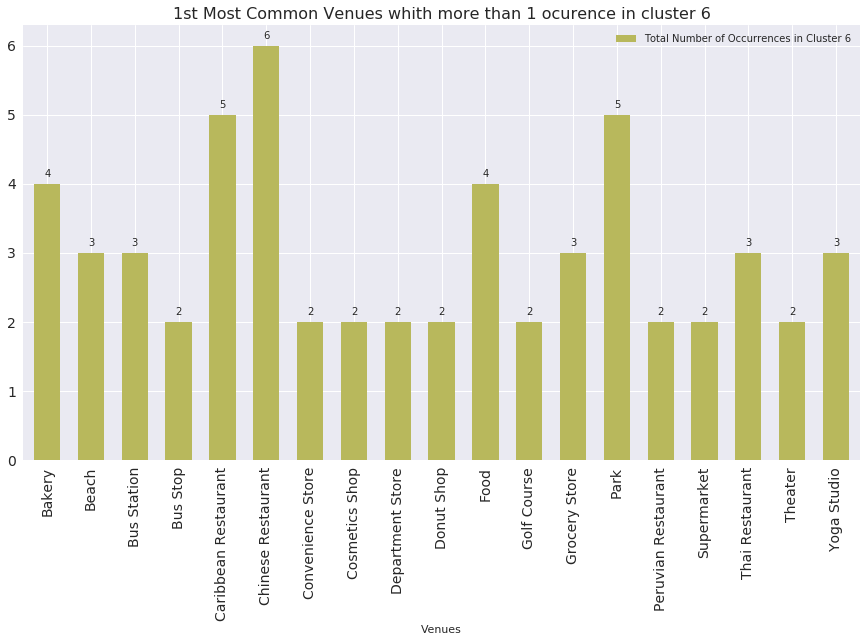

In [91]:
ax = cluster_6_analisis.plot(kind = 'bar',
                 figsize = (15, 8),
                 width = 0.6,
                 color = ['#b8b85c'],
                 fontsize = 14
                 )
ax.set_title('1st Most Common Venues whith more than 1 ocurence in cluster 6', fontsize = 16)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for percentage in ax.patches:
    ax.annotate(str(percentage.get_height()), xy =(percentage.get_x()+0.23, percentage.get_height()+0.10))

## Cluster 7

In [78]:
cluster_7 = both_merged.loc[both_merged['Cluster Labels'] == 6, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_7.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,Mill Island,Pool,Women's Store,Event Service,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant


In [87]:
cluster_7_analisis = cluster_7[['Neighborhood', '1st Most Common Venue']]
cluster_7_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 7', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_7_analisis = cluster_7_analisis.groupby('Venues').count()

cluster_7_analisis

,Total Number of Occurrences in Cluster 7
Venues,
Pool,1


## Cluster 8

In [79]:
cluster_8 = both_merged.loc[both_merged['Cluster Labels'] == 7, both_merged.columns[[1] + list(range(5, both_merged.shape[1]))]]
cluster_8.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Eastchester,Caribbean Restaurant,Deli / Bodega,Bus Stop,Diner,Bowling Alley,Fast Food Restaurant,Metro Station,Bus Station,Bakery,Seafood Restaurant
7,Woodlawn,Deli / Bodega,Pub,Bar,Food Truck,Grocery Store,Auto Workshop,Donut Shop,Rental Car Location,Italian Restaurant,American Restaurant
28,Throgs Neck,Deli / Bodega,Sports Bar,Italian Restaurant,Asian Restaurant,Coffee Shop,Juice Bar,American Restaurant,Bar,Pizza Place,Farmers Market
34,Belmont,Italian Restaurant,Pizza Place,Dessert Shop,Deli / Bodega,Food & Drink Shop,Bakery,Market,Liquor Store,Fish Market,Cycle Studio
39,Edgewater Park,Italian Restaurant,Pizza Place,Deli / Bodega,Ice Cream Shop,American Restaurant,Donut Shop,Park,Asian Restaurant,Juice Bar,Coffee Shop


In [80]:
cluster_8_analisis = cluster_8[['Neighborhood', '1st Most Common Venue']]
cluster_8_analisis.rename(columns = {'Neighborhood': 'Total Number of Occurrences in Cluster 8', '1st Most Common Venue':'Venues'}, inplace=True)
cluster_8_analisis = cluster_8_analisis.groupby('Venues').count()
# 1st Most Common Venues whith more than 1 ocurence in cluster 1
cluster_8_analisis = cluster_8_analisis.loc[cluster_8_analisis['Total Number of Occurrences in Cluster 8'] > 1]
cluster_8_analisis

,Total Number of Occurrences in Cluster 8
Venues,
Bagel Shop,2
Beach,2
Bus Stop,6
Caribbean Restaurant,2
Deli / Bodega,12
Italian Restaurant,5


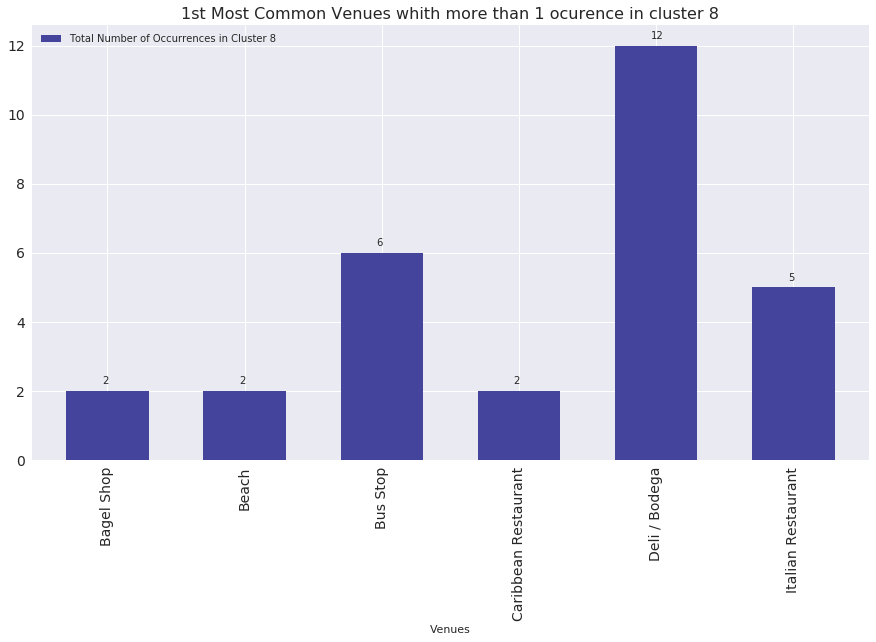

In [92]:
ax = cluster_8_analisis.plot(kind = 'bar',
                 figsize = (15, 8),
                 width = 0.6,
                 color = ['#44449d'],
                 fontsize = 14
                 )
ax.set_title('1st Most Common Venues whith more than 1 ocurence in cluster 8', fontsize = 16)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for percentage in ax.patches:
    ax.annotate(str(percentage.get_height()), xy =(percentage.get_x()+0.26, percentage.get_height()+0.20))

# Results and Discussion

Our analysis shows a large number of similarities in both cities and without a doubt Foursquare has provided us with relevant information and notorious similarity between neighborhoods that were segmented using unsupervised learning with the Kmeans algorithm in which we divided the information into eight clusters related to the categories of most important and visited places.
On the one hand, New York with a population of around eight million, has five boroughs and three hundred six neighborhoods. As we could see in the bar chart the three most important categories within the most visited and qualified places in the city are: 
1. Pizza Place
2. Italian Restaurant
3. Deli / Winery

On the other hand, Toronto has a population of around three million, four boroughs and thirties and nine neighborhoods. If we look at the information provided by Foursquare and later in the bar chart we see that the three most important categories within the most visited and qualified places in the city are:
1. Cofee Shop
2. Cafe
3. Park

However, at the moment that we join both datasets and through the Kmeans algorithm we form eight clusters which indicate important characteristics that we can appreciate in similarities of both cities, without a doubt this information is clearly explained with the bar graphs, which I invite to You to observe.

# Conclusion

Purpose of this project was to identify the similarities and differences between the city of New York and the city of Toronto, a task that was not simple due to the large number of factors that can influence the outcome in addition to the vision and purpose have when analyzing the data. As a result of this project we can conclude that despite the greographic differences between the two cities together with the population difference, we were able to successfully segment both cities into eight clusters which show us remarkable characteristics that the neighborhoods between both cities share, mainly for the most common places that thanks at foursquare we have been able to recover.

I hope this notebook is useful to someone who aspires to visit or live in either of the two New York or Toronto cities, or even to someone who has a business interest.